# Optical Gating Alignment Algorithms

## Scope of this Notebook

This notebook accompanies our python module for optical gating reference period alignment algorithms: optical_gating_alignment, which can be found at https://github.com/Glasgow-ICG/optical-gating-alignment.

If you have downloaded the repository from the above link then everything required for this notebook should be in the right place.
This includes a data set that contains 30 multipage .tif files showing example reference heartbeats collected every approx. 15 minutes during a real adaptive optical gating timelapse experiment. This data folder also includes two .csv data files.
One with the determined period, timestamp and drift for each reference set.
One with manually identified target frames for each reference set from five different scorers.

This notebook will install the optical_gating_alignment module in your Python environment using pip.
If you do not want this you should edit the notebook first.

The purpose of this notebook is to produce a demonstration of the quality of synchronisation algorithms. Specifically:

* A plot of the stability of different algorithms for adaptive optical gating-based phase-locking by comparing human and computational derived target frames, i.e. figure 3b. Please note that neither the human or computational derived targets can be considered 'ground truths' and are compared to indicate stability not precision/accuracy.
* 'Flick books', each showing the phase-lock over time (compared to the mean manual result) for different algorithms

For users interested in following the outputs of our adaptive optical gating systems, i.e. the phase-locked target frame, we draw their attentions to the lines that call the `oga.process_sequence()` function, particularly the output variable `global_roll_factor`.

## Related Publications

* TODO
* TODO
* TODO

## Import Modules

In [1]:
import os

# Numpy, Scipy, Pandas and Scikits
import numpy as np
import pandas as pd
from skimage import io

# Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Install Package
# !pip install optical_gating_alignment # TODO publish
!poetry build
!pip install --no-deps --ignore-installed ../dist/optical_gating_alignment-2.0.0-py3-none-any.whl  # stupidly this is not this venv
import optical_gating_alignment.optical_gating_alignment as oga
oga.set_logger(level="SUCCESS", format="jupyter")  # change to "WARNING", "INFO" or "DEBUG" for more information

print('Fin')

Building optical-gating-alignment (2.0.0)
 - Building sdist
 - Built optical-gating-alignment-2.0.0.tar.gz

 - Building wheel
 - Built optical_gating_alignment-2.0.0-py3-none-any.whl
Processing /home/chas/git/optical-gating-alignment/dist/optical_gating_alignment-2.0.0-py3-none-any.whl
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/lib/python3.8/site-packages/optical_gating_alignment-2.0.0.dist-info'
Consider using the `--user` option or check the permissions.

Fin


## Local Functions

In [2]:
def circularMean(anglesInRad,axis=1):
    '''In order to deal with the wrapped nature of the data we're dealing with, this function works out the angular or circular mean.
    It is very important to note that the values must be in radians for this to work.'''
    x = np.nansum(np.cos(anglesInRad),axis=axis)
    y = np.nansum(np.sin(anglesInRad),axis=axis)
    return np.arctan2(y,x)%(2*np.pi)


def circularMeanScaled(values,divisor,axis=1):
    '''Wrapper function that takes any values and their divisors, converts them to radians and calculates the circular mean.'''
    # Convert to radians
    radians = 2*np.pi*values/divisor
    return circularMean(radians,axis=axis)*divisor/(2*np.pi)

print('Fin')

Fin


## Load Reference Information

Here we load some provided information about the time series from `periods.txt`. Each row contains six entries:
* reference `Number` (i.e. sequence order)
* `Period` length (in frames)
* reference heartbeat image drift in X (`Drift_X`)
* and `Drift_Y`

The first row should contain headers (that ideally match the above).

Note that the period length, timestamp and drift are all contained in `period.txt` an output of the main software that can be found with the reference heartbeat images. We have only compiled this information into a single file for demonstration purposes.

In [3]:
root = "./data"

periods = pd.read_csv(os.path.join(root,"periods.csv"),
                      sep=',',
                      header=0,
                      index_col=0,
                      names=['Number','Period','Drift_X','Drift_Y'])

# Initialise columns for algorithms
algorithms = ['Adaptive','Dynamic','SuperDynamic']
for alg in algorithms:
    periods[alg] = np.nan

# display(periods.sample(5))

print('Fin')

Fin


## Load Manual Results

If manual results are not available, i.e. if you're using data that is not the provided example, sets a flag. All plots and flick books will then be absolute rather than relative to the manually derived results.

In [4]:
if os.path.exists(os.path.join(root,"scores.csv")):
    # For quick reference to all human scorers
    scorers = ['CJN','JT','CB','AB','FB']

    # Load manual results as pd.DataFrame
    humanScores = pd.read_csv(os.path.join(root,"scores.csv"),
                          sep=',',
                          header=0,
                          index_col=0,
                          names=['Number']+scorers)
#     display(humanScores.sample(5))

    # determine starting period
    # we always start with the first human scores given
    # so we can pick a good initial target
    start = humanScores.index[0]
    periods = periods.loc[start::,:]

    # Merge with periods.csv data
    results = periods.join(humanScores,how='outer')
#     display(results)

    # Identify consensus start in frames (using a circular mean)
    initialTarget = circularMeanScaled(results[scorers].dropna().iloc[0].values,results['Period'].dropna().iloc[0],axis=0)
    print('Intial target: {0} frames'.format(initialTarget))

    # Convert Frames to Radians
    for scorer in scorers:
        results[scorer] = (2*np.pi*(results[scorer]/results['Period']))%(2*np.pi)

    # Calculate mean 'scorer'
    means = circularMean(results[scorers],axis=1)
    
    # Shift to difference from mean
    for scorer in scorers:
        results[scorer] = results[scorer]-means

    # Fix wrapping issues
    results[scorers] = np.where(results[scorers]<-np.pi,results[scorers]+(2*np.pi),results[scorers])
    results[scorers] = np.where(results[scorers]>np.pi,results[scorers]-(2*np.pi),results[scorers])

#     display(results.head(10))
    
    # set flag
    relative_to_manual = True
else:
    # set flag
    relative_to_manual = False
    results = periods.copy()
    initialTarget = circularMean([0.0], axis=0)  # toy initial target of 0.0

print('Fin')

,Period,Drift_X,Drift_Y,Adaptive,Dynamic,SuperDynamic,CJN,JT,CB,AB,FB
Number,,,,,,,,,,,
90,34.282163,0,0,NaN,NaN,NaN,15.0,13.0,13.0,14.0,13.0
91,34.770042,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,34.270603,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,34.783085,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,34.398780,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
476,32.154912,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477,32.395357,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478,32.242271,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Intial target: 13.597565048856001 frames
Fin


## Identify Phase-locked Target Frames in a Series of Reference Heartbeats

### Using Standard Sum of Squared Differences

The next cell takes a series of real reference heartbeatsand runs the original adaptive optical gating algorithm based on sum of squared differences to identify a phase-locked target frame throughout time.

Please see the Python module documentation for all details.

In [5]:
# Set-Up arrays for keeping history
target = initialTarget.copy()
sequence_history = None
period_history = None
drift_history = None
shift_history = None

for ref in results.index:
    # Load reference period images
    this_sequence = io.imread(os.path.join(root,'reference{0:04d}.tif'.format(ref)))
    this_period = results.loc[ref,'Period']  # as stored in periods.csv
    this_drift = (results.loc[ref,'Drift_X'], results.loc[ref,'Drift_Y'])  # as stored in periods.csv
    
    # Process new reference period using the 'cross correlation' ("cc") algorithm, note this is sum of squared differences
    # We will use the default Fast Fourier Transform form of this algorithm (as it's the fastest); see documentation for other methods.
    # By default this algorithm will resample a period to be 80 frames long
    (sequence_history,
     period_history,
     drift_history,
     shift_history,
     global_solution,
     target) = oga.process_sequence(this_sequence,
                                    this_period,
                                    [0,0],#this_drift,
                                    sequence_history=sequence_history,
                                    period_history=period_history,
                                    drift_history=drift_history,
                                    shift_history=shift_history,
                                    max_offset=3,
                                    ref_seq_id=0,
                                    ref_seq_phase=initialTarget,
                                    algorithm="cc")
    
    # Convert target to radians
    target_radians = 2 * np.pi * target / this_period
    
    # Store results
    results.loc[ref,'Adaptive'] = target_radians

print('Fin')

Processing new sequence (Period: 34.282163; Drift: [0, 0]).
Creating new histories.
New target (base this_period): 13.597565048856001
Processing new sequence (Period: 34.770042; Drift: [0, 0]).
New target (base this_period): 15.466549135317342
Processing new sequence (Period: 34.270603; Drift: [0, 0]).
New target (base this_period): 15.418519861565272
Processing new sequence (Period: 34.783085; Drift: [0, 0]).
New target (base this_period): 13.325002020949142
Processing new sequence (Period: 34.39878; Drift: [0, 0]).
New target (base this_period): 17.13416954706582
Processing new sequence (Period: 34.616525; Drift: [0, 0]).
New target (base this_period): 1.1662308998461755
Processing new sequence (Period: 34.120756; Drift: [0, 0]).
New target (base this_period): 13.110384893395771
Processing new sequence (Period: 34.44466; Drift: [0, 0]).
New target (base this_period): 18.092227120490314
Processing new sequence (Period: 34.013238; Drift: [0, 0]).
New target (base this_period): 29.97885

### Using Cascading Needleman-Wunsch Algorithm

The next cell takes a series of real reference heartbeatsand runs the new adaptive optical gating algorithm based on the cascading Needleman-Wunsch algorithm to identify a phase-locked target frame throughout time.

Please see the Python module documentation for all details.

In [6]:
from optical_gating_alignment import helper as hlp

# Set-Up arrays for keeping history
sequence_history = None
period_history = None
drift_history = None
shift_history = None
global_solution = None

for ref in results.index:
    # Load reference period images
    this_sequence = hlp.interpolate_image_sequence(io.imread(os.path.join(root,'reference{0:04d}.tif'.format(ref)))[2:-2], results.loc[ref,'Period'], interpolation_factor=80/results.loc[ref,'Period'])[:80]
#     this_sequence = io.imread(os.path.join(root,'reference{0:04d}.tif'.format(ref)))[2:-2]
    this_period = 80#results.loc[ref,'Period']  # as stored in periods.csv
    this_drift = (results.loc[ref,'Drift_X'], results.loc[ref,'Drift_Y'])  # as stored in periods.csv
    
    # Process new reference period using the 'cross correlation' ("cc") algorithm, note this is sum of squared differences
    # We will specifically use the default Fast Fourier Transform form of this algorithm (as it's the fastest); see documentation for other methods.
    # By default this algorithm will resample a period to be 80 frames long
    (sequence_history,
     period_history,
     drift_history,
     shift_history,
     global_solution,
     target) = oga.process_sequence(this_sequence,
                                    this_period,
                                    [0,0],#this_drift,
                                    sequence_history=sequence_history,
                                    period_history=period_history,
                                    drift_history=drift_history,
                                    shift_history=shift_history,
                                    global_solution=global_solution,
                                    max_offset=3,
                                    ref_seq_id=0,
                                    ref_seq_phase=initialTarget*80/results['Period'].values[0],
                                    algorithm="cnw")
    
    # Convert target to radians
    target_radians = 2 * np.pi * target / this_period
    
    # Store results
    results.loc[ref,'Dynamic'] = target_radians

print('Fin')

Processing new sequence (Period: 80; Drift: [0, 0]).
Creating new histories.
New target (base this_period): 31.73093844482567
Processing new sequence (Period: 80; Drift: [0, 0]).
New target (base this_period): 35.73093844482567
Processing new sequence (Period: 80; Drift: [0, 0]).
New target (base this_period): 35.73093844482569
Processing new sequence (Period: 80; Drift: [0, 0]).
New target (base this_period): 30.73093844482571
Processing new sequence (Period: 80; Drift: [0, 0]).
New target (base this_period): 39.730938444825625
Processing new sequence (Period: 80; Drift: [0, 0]).
New target (base this_period): 2.7309384448256537
Processing new sequence (Period: 80; Drift: [0, 0]).
New target (base this_period): 30.730938444825682
Processing new sequence (Period: 80; Drift: [0, 0]).
New target (base this_period): 41.730938444825455
Processing new sequence (Period: 80; Drift: [0, 0]).
New target (base this_period): 70.73093844482591
Processing new sequence (Period: 80; Drift: [0, 0]).
N

### Using cNW and interpolation

The next cell takes a series of real reference heartbeats, captured once every three adaptive optical gating stacks, and runs the adaptive optical gating algorithms used to identify a phase-locked target frame across 18 hours of time-lapse imaging.

The key bit of code here is the calling of `cnw.processNewReferenceSequence()`, which is used in the live system.

For ease the documentation from the Python file explaining the inputs and outputs is copied below:
```
Inputs:
* rawRefFrames: a PxMxN numpy array representing the new reference frames (or a list of numpy arrays representing the new reference frames)
* thisPeriod: the period for rawRefFrames (caller must determine this)
* thisDrift: the drift for rawRefFrames (caller must determine this)
 * if None no drift correction is used
* resampledSequences: a list of resampled, previous reference frames
* periodHistory: a list of the previous periods for resampledSequences
* driftHistory: a list of the previous drifts for resampledSequences
 * if no drift correction is used, this is a dummy variable
* shifts: a list of shifts previously calculated for resampledSequences
* knownPhaseIndex: the index of resampledSequences for which knownPhase applies
* knownPhase: the phase (index) we are trying to match in knownPhaseIndex
* numSamplesPerPeriod: the number of samples to use in resampling
* maxOffsetToConsider: how far apart historically to make comparisons
 * should be used to prevent comparing sequences that are far apart and have little similarity

Outputs:
* resampledSequences: updated list of resampled reference frames
* periodHistory: updated list of the periods for resampledSequences
* driftHistory: updated list of the drifts for resampledSequences
 * if no drift correction is used, this is a dummy variable
* shifts: updated list of shifts calculated for resampledSequences
* globalShiftSolution[-1]: roll factor for latest reference frames
* residuals: residuals on least squares solution'''
```

## Normalise Computed Results

Same as done for human scorers above.

In [7]:
if relative_to_manual:
    for alg in algorithms:
        results[alg] = results[alg]-means
        # Boundary wrapping
        results.loc[results[alg]<-np.pi,alg] += 2*np.pi
        results.loc[results[alg]>np.pi,alg] -= 2*np.pi
    
print('Fin')

Fin


## Combine and Melt Dataframes

This makes plotting easier with Seaborn.

In [9]:
# Melt arrays for easier plotting
# but drop times we don't have manual results for
resultsMelted = results.dropna(how='any',subset=scorers).reset_index(level='Number')

if relative_to_manual:
    humansMelted = resultsMelted.melt(id_vars=['Number'], var_name='Scorer', value_vars=scorers, value_name='Frame')
    humansMelted = humansMelted.dropna()

algorithmsMelted = resultsMelted.melt(id_vars=['Number'], var_name='Algorithm', value_vars=algorithms, value_name='Frame')
algorithmsMelted = algorithmsMelted.dropna()

print('Fin')

Fin


## Plots

Fin


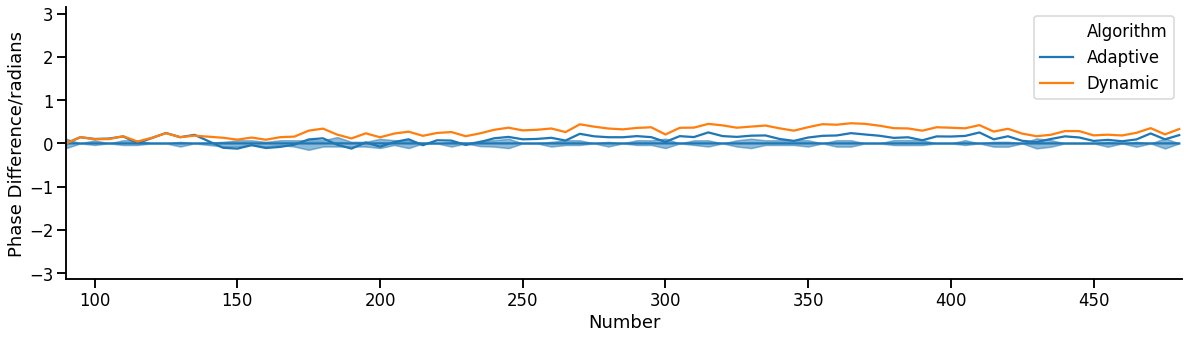

In [10]:
# Plot Main Result
with sns.plotting_context("talk"):
    f, ax = plt.subplots(1, figsize=[20,5])
    
    if relative_to_manual:
        sns.lineplot(x='Number',y='Frame', data=humansMelted, estimator='mean', err_kws={'alpha':0.5}, ax=ax)
    sns.lineplot(x='Number',y='Frame', hue='Algorithm', data=algorithmsMelted, sizes=50, ax=ax)
    
    ax.set_xlim([resultsMelted['Number'].values[0], resultsMelted['Number'].values[-1]+1])
    ax.set_xlabel('Number')
    if relative_to_manual:
        ax.set_ylim([-np.pi,np.pi])  # Set to pass to zoom in
    ax.set_ylabel('Phase Difference/radians')
 
    sns.despine(ax=ax)
    
    f.show()

print('Fin')